In [1]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [2]:
import sys
print(sys.executable)



C:\Users\USER\anaconda3\envs\tf_env\python.exe


In [3]:
dataset_dir= r"C:\Users\USER\OneDrive\Documents\GitHub\Week-1\garbage\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [6]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [7]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


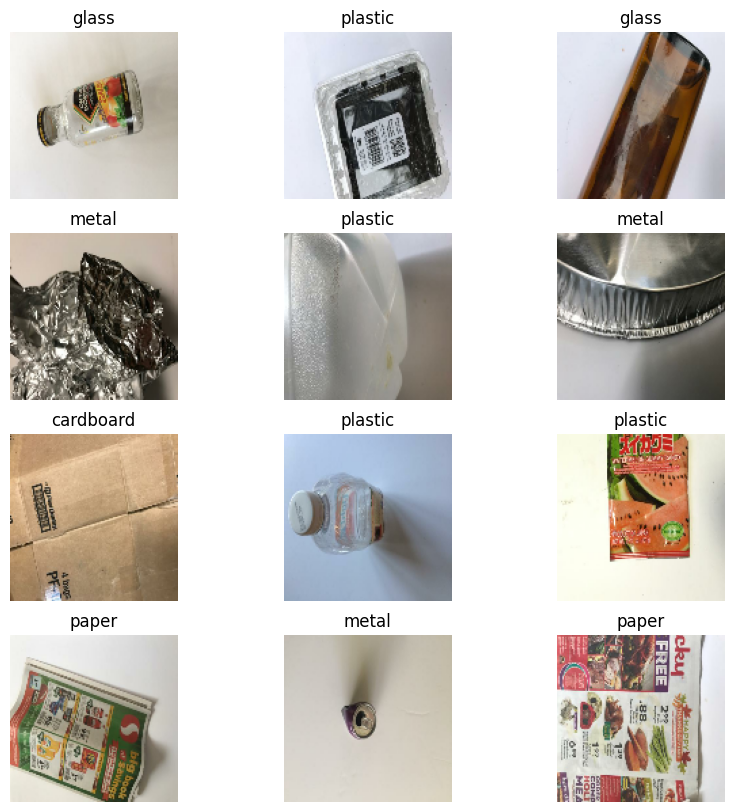

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [9]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts


In [10]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


In [11]:
import matplotlib.pyplot as plt

def simple_bar_plot(data_dict, title):
    labels = list(data_dict.keys())
    values = list(data_dict.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, color='skyblue')
    
    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.1f}%', ha='center', va='bottom')

    plt.title(title)
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


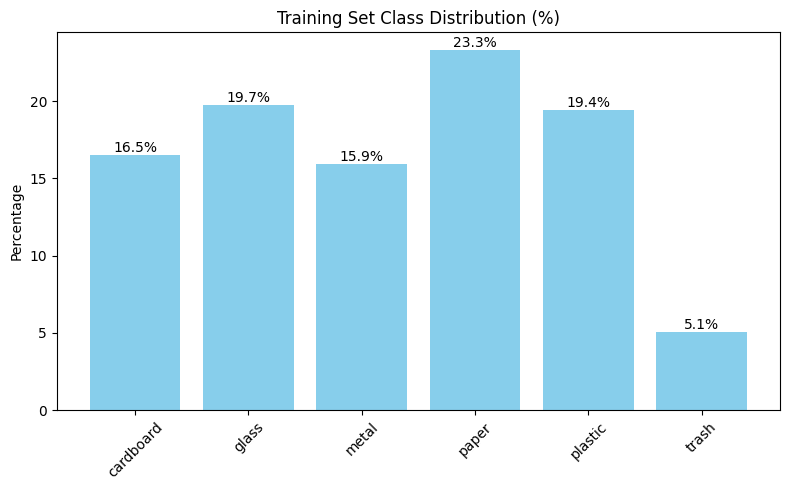

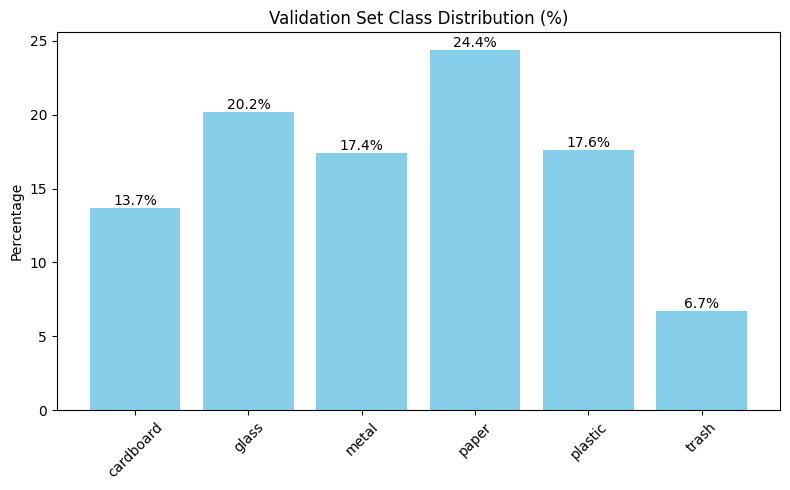

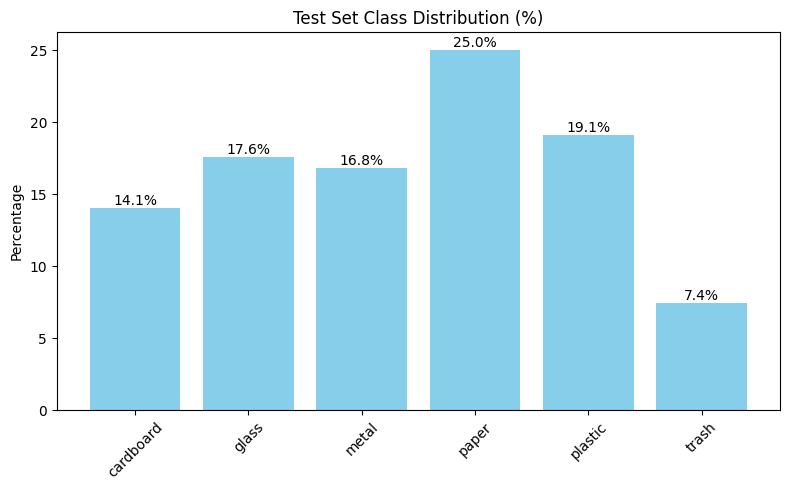

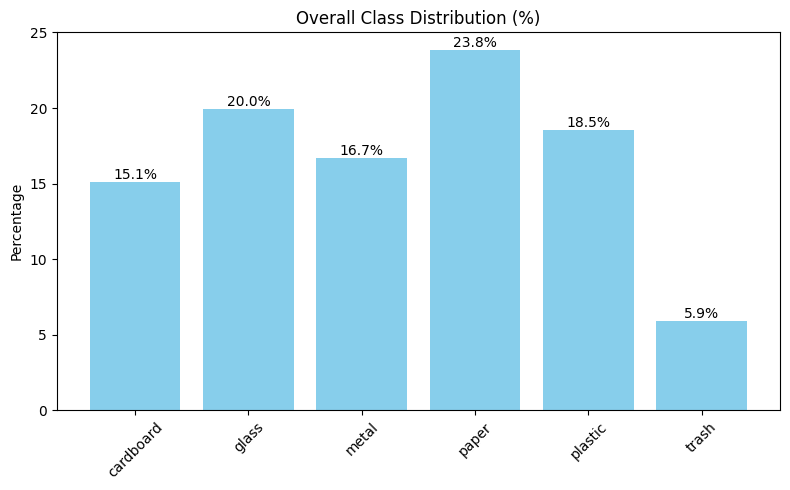

In [12]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [13]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

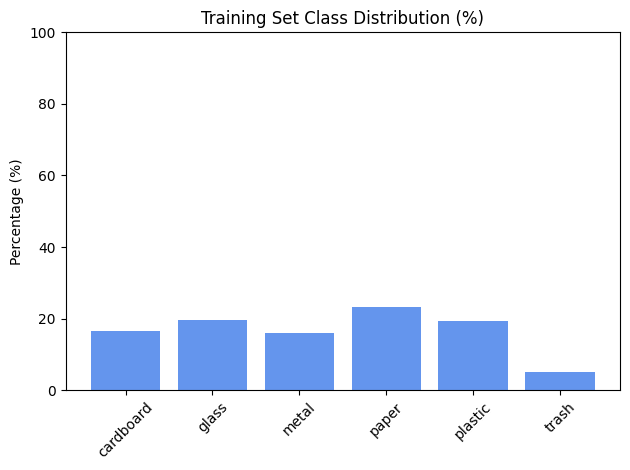

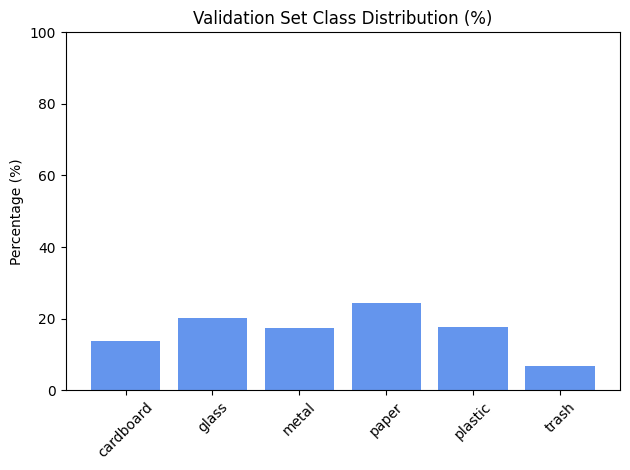

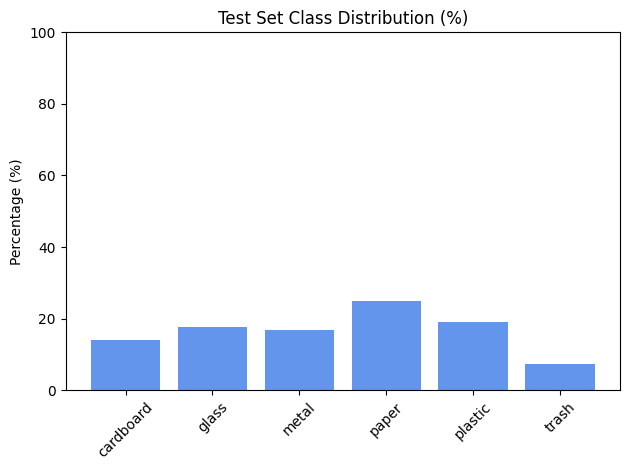

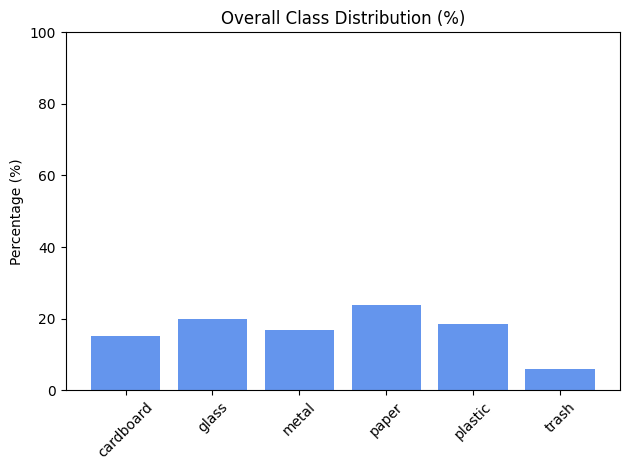

In [14]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [15]:

# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [16]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [17]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [18]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



In [19]:
from tensorflow.keras.applications import EfficientNetV2B2


In [20]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



In [21]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [22]:
from tensorflow.keras.models import Sequential


In [23]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])


In [24]:
from tensorflow.keras import layers


In [25]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [26]:
# ✅ Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Rescaling, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

# ✅ Data Augmentation (define before using it in the model)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

# ✅ Load the EfficientNetV2B2 base model (excluding top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),
                              include_preprocessing=True, weights='imagenet')
base_model.trainable = True  # Set to False if you want to freeze base layers

# ✅ Build the full model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Replace 6 with your actual number of classes
])

# ✅ Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model built and compiled successfully!")
model.summary()


✅ Model built and compiled successfully!


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [27]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [28]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [29]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


In [30]:
# Set the number of epochs to train the model
epochs = 10  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.2727 - loss: 1.7410 - val_accuracy: 0.5564 - val_loss: 1.3160
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5947 - loss: 1.1886 - val_accuracy: 0.6851 - val_loss: 0.9545
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7240 - loss: 0.8209 - val_accuracy: 0.7545 - val_loss: 0.7267
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7953 - loss: 0.5930 - val_accuracy: 0.7861 - val_loss: 0.6089
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8369 - loss: 0.4951 - val_accuracy: 0.8198 - val_loss: 0.5221
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8610 - loss: 0.4232 - val_accuracy: 0.8317 - val_loss: 0.4991
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8851 - loss: 0.3281 - val_accuracy: 0.8416 - val_loss: 0.4573
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8997 - loss: 0.2930 - val_accuracy: 0.8416 - val_loss

In [31]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    r"C:\Users\USER\OneDrive\Documents\GitHub\Week-1\garbage\TrashType_Image_Dataset",         # Replace with your training folder path
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(124, 124),           # Match this to your model input
    batch_size=32
)

val_ds = image_dataset_from_directory(
    r"C:\Users\USER\OneDrive\Documents\GitHub\Week-1\garbage\TrashType_Image_Dataset",         # Same path, but subset is different
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [32]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,168,910 (99.83 MB)

 Trainable params: 8,695,540 (33.17 MB)

 Non-trainable params: 82,288 (321.44 KB)

 Optimizer params: 17,391,082 (66.34 MB)

In [33]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_2 (Rescaling)       │ (None, 124, 124, 3)       │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_2               │ (None, 124, 124, 3)       │               0 │ rescaling_2[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ normalization_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 62, 62, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 62, 62, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 62, 62, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 62, 62, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 62, 62, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 62, 62, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 62, 62, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 62, 62, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [34]:
import os
from collections import Counter

# Replace with your training folder path
train_dir = r"C:\Users\USER\OneDrive\Documents\GitHub\Week-1\garbage\TrashType_Image_Dataset"

# Get class names (folder names inside train_dir)
class_names = os.listdir(train_dir)

# Count number of images in each class
class_counts = Counter()
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("Class counts:", class_counts)


Class counts: Counter({'paper': 594, 'glass': 501, 'plastic': 482, 'metal': 410, 'cardboard': 403, 'trash': 137})


In [35]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert labels to numeric indices
class_indices = {name: i for i, name in enumerate(sorted(class_counts))}
labels = []
for class_name, count in class_counts.items():
    labels.extend([class_indices[class_name]] * count)

# Compute class weights
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights_arr))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.0450785773366418), 1: np.float64(0.8406520292747838), 2: np.float64(1.0272357723577237), 3: np.float64(0.7090347923681257), 4: np.float64(0.873789764868603), 5: np.float64(3.0742092457420926)}


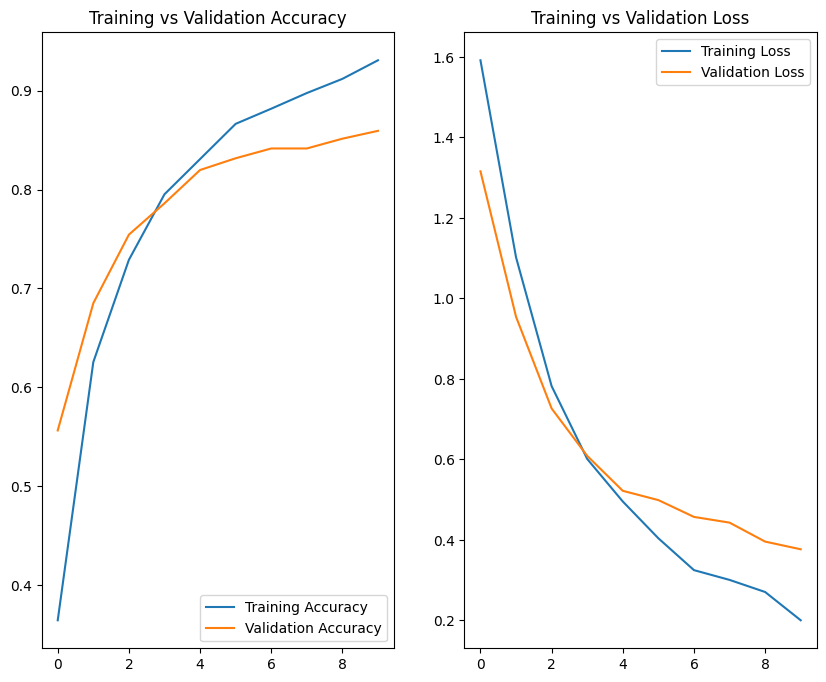

In [36]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [37]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - accuracy: 0.8531 - loss: 0.4148
Test accuracy is0.8555, Test loss is 0.3692


In [38]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy is {accuracy:.4f}, Validation loss is {loss:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.9375 - loss: 0.2054
Validation accuracy is 0.9228, Validation loss is 0.2219


In [39]:
test_ds_eval = image_dataset_from_directory(
    r"C:\Users\USER\OneDrive\Documents\GitHub\Week-1\garbage\TrashType_Image_Dataset",
    image_size=(124, 124),
    batch_size=32,
    shuffle=False
)


Found 2527 files belonging to 6 classes.


In [40]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.9294 - loss: 0.2124
Test accuracy is0.9185, Test loss is 0.2440


In [41]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step
[[388   0   3  12   0   0]
 [  0 429  60   0   6   6]
 [  1   2 401   0   0   6]
 [ 23   1   5 540   0  25]
 [  1  11  17   3 434  16]
 [  0   0   3   5   0 129]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       403
           1       0.97      0.86      0.91       501
           2       0.82      0.98      0.89       410
           3       0.96      0.91      0.94       594
           4       0.99      0.90      0.94       482
           5       0.71      0.94      0.81       137

    accuracy                           0.92      2527
   macro avg       0.90      0.92      0.91      2527
weighted avg       0.93      0.92      0.92      2527



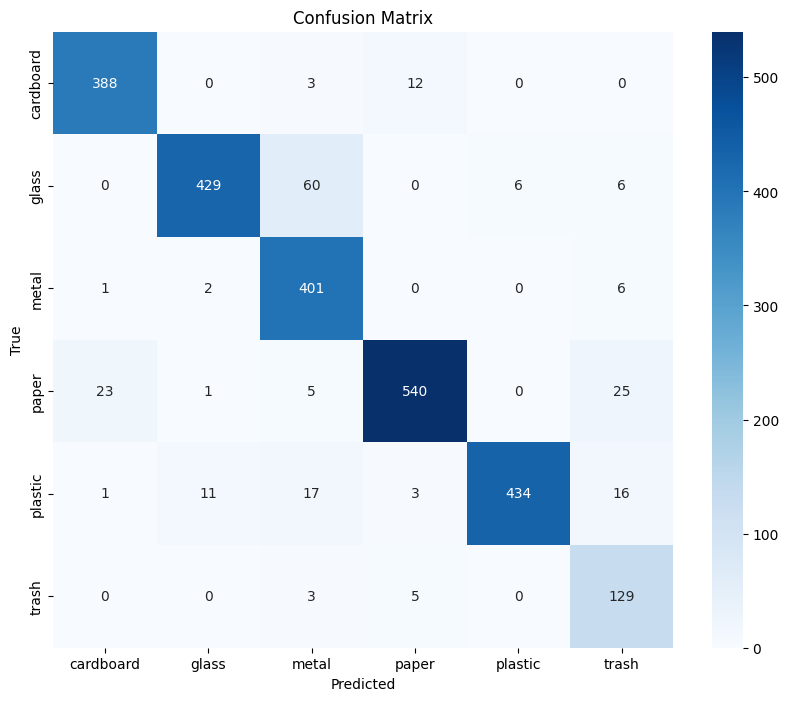

In [42]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


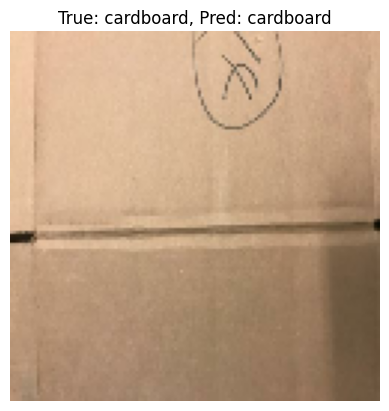

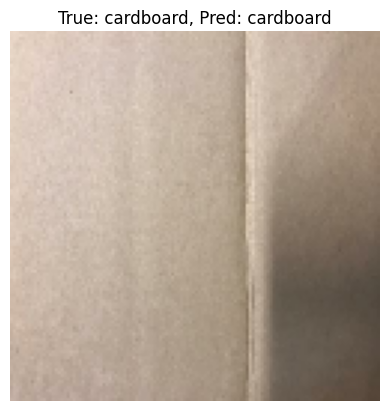

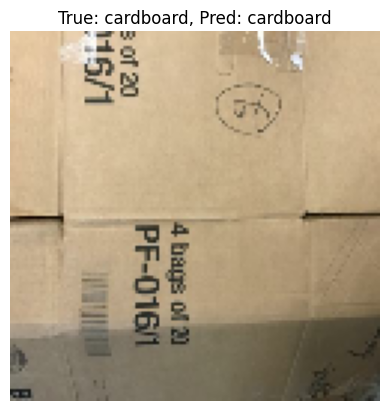

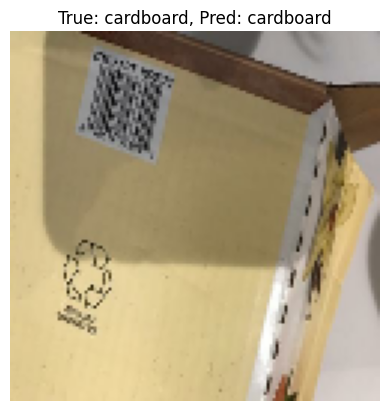

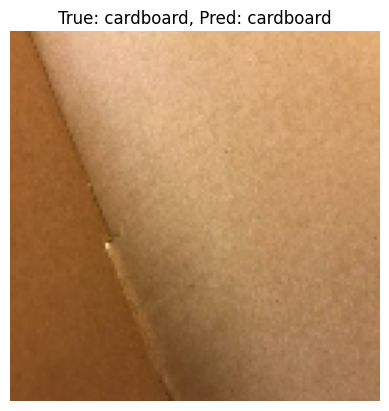

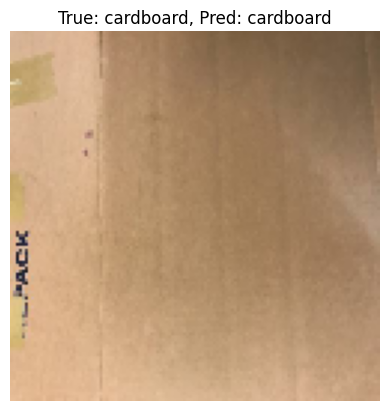

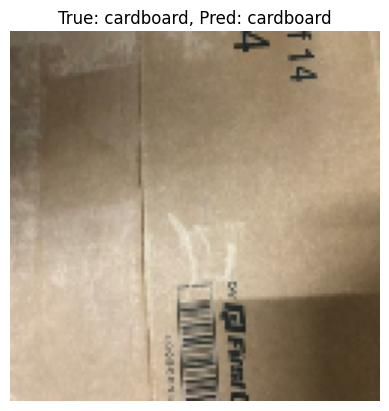

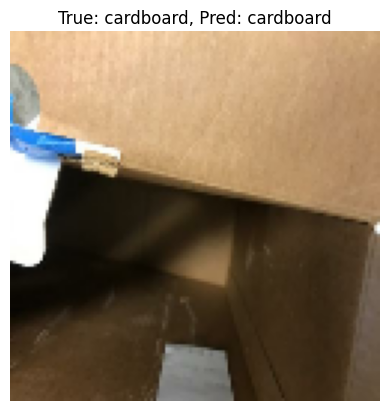

In [43]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [19]:
import tensorflow as tf

model = tf.keras.models.load_model('EfficientNetV2B2.keras')


In [20]:
# Save the model (includes architecture, weights, and training configuration)
model.save('EfficientNetV2B2.keras')

# Later: Load the saved model for inference or continued training
model = tf.keras.models.load_model('EfficientNetV2B2.keras')


In [23]:
!pip uninstall gradio gradio-client -y



Found existing installation: gradio 5.35.0
Uninstalling gradio-5.35.0:
  Successfully uninstalled gradio-5.35.0
Found existing installation: gradio_client 1.10.4
Uninstalling gradio_client-1.10.4:
  Successfully uninstalled gradio_client-1.10.4


In [25]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from PIL import Image

# --- Load your trained model ---
model = tf.keras.models.load_model("EfficientNetV2B2.keras")

# --- Define your class names ---
# Adjust this list based on your dataset
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# --- Define the image classification function ---
def classify_image(img):  
    # Resize image to 124x124 (should match training input size)
    img = img.resize((124, 124))  
    
    # Convert to NumPy array and preprocess
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    prediction = model.predict(img_array)
    
    # Get top class and confidence
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]
    
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

# --- Build Gradio interface ---
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Garbage Image Classifier",
    description="Upload an image of trash to classify it."
)

# --- Launch interface ---
iface.launch(share=True)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\middleware\errors.py", line 165, in __call__
 

Running on local URL:  http://127.0.0.1:7868


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\middleware\errors.py", line 165, in __call__
 


Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\uvicorn\protocols\http\h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\middleware\errors.py", line 187, in __call__
    raise exc
  File "C:\Users\USER\anaconda3\envs\tf_env\lib\site-packages\starlette\middleware\errors.py", line 165, in __call__
 